 Theunderlying SC was constructed by (i) drawing 400 random points in the unit square;(ii) generating a triangular lattice via Delauney triangulation; (iii) eliminating edgesinside two predefined regions; and (iv) defining all triangles to be faces.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy as sc
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import random

import pickle

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.graph_generator import modular_graph
from simplicial_kuramoto.integrators import *
from simplicial_kuramoto import plotting

In [6]:
def get_delauney_holes(n_points, centre_hole_1, centre_hole_2,   radius):


    x = np.random.rand(n_points)
    y = np.random.rand(n_points)
    points = np.vstack([x,y]).T


    tri = Delaunay(points)

    edge_list = []
    
    idx_inside_1 = encloses(centre_hole_1,points,radius)[1]
    idx_inside_2 = encloses(centre_hole_2,points,radius)[1]
    
    idx_inside = np.hstack([idx_inside_1,idx_inside_2])
    
    for t in tri.simplices:
        
        if t[0] not in idx_inside and t[1] not in idx_inside:
            edge_list.append([t[0], t[1]])
     
        if t[1] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[1], t[2]])

        if t[0] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[0], t[2]])   


            
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])
    
    
    return g, points


def encloses(centre, points, radius):
    inside_hole = (cdist(centre, points, 'euclidean') <= radius)
    idx_inside = np.where(inside_hole )
    
    return idx_inside




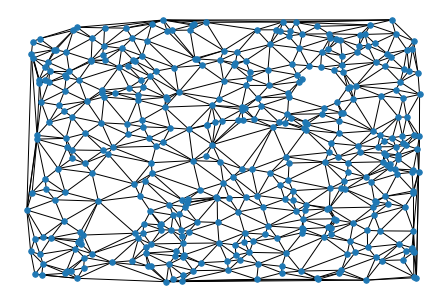

In [7]:

centre_hole_1 = np.array([[0.25,0.25]])
centre_hole_2 = np.array([[0.75,0.75]])
radius = 0.05

graph, points = get_delauney_holes(400,centre_hole_1,centre_hole_2, radius)
pos = dict(enumerate(points))
nx.draw(graph,pos,node_size=30)



In [ ]:
plt.figure()
nx.draw_networkx_nodes(graph, pos=points, node_size=5)
nx.draw_networkx_edges(graph, pos=points)

labels = dict(((u, v), d) for d, (u, v) in enumerate(graph.edges))


np.random.seed(0)
initial_phase = np.random.uniform(0, 2 * np.pi, len(graph.edges))


t_max = 500
n_t = 10

complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t)
plotting.plot_edge_kuramoto(edge_result)
    # plt.savefig("phases_no_faces.png")

plotting.plot_order_parameter(edge_result.y, return_op=False, plot=True)
    
plt.figure()
nx.draw_networkx_nodes(graph, pos=points, node_size=5)
nx.draw_networkx_edges(
        graph,
        pos=points,
        edge_color=edge_result.y[:, -1],
        edge_cmap=plt.get_cmap("bwr"),
        width=5,
        edge_vmin=np.min(edge_result.y),
        edge_vmax=np.max(edge_result.y),
    )

We created 768 faces
